# Homework 1 
## Romina Doz
### Algorithmic Design - 25/03/2021

First of all, we can import the matrix template class and the gauss algorithm (naive implementation of the matrix product)

In [1]:
from matrix import gauss_matrix_mult, Matrix, get_matrix_quadrants

1) Implement the strassen matrix mult function to multiply two $2^n × 2^n$ matrices by using the Strassen’s algorithm

In [2]:
def strassen_matrix_mult(A: Matrix, B: Matrix) -> Matrix:

    if (A.num_of_cols != B.num_of_rows):
        raise ValueError('The number of columns of `A` is different from the number of rows of `B` ')
   
    #Base case
    if max(A.num_of_rows, B.num_of_cols, A.num_of_cols) < 32:
        return gauss_matrix_mult(A, B)
    
    #Recursive step
    A11, A12, A21, A22 = get_matrix_quadrants(A)
    B11, B12, B21, B22 = get_matrix_quadrants(B)

    #First batch of sums (Theta(n^2))
    S1 = B12 - B22
    S2 = A11 + A12
    S3 = A21 + A22
    S4 = B21 - B11
    S5 = A11 + A22
    S6 = B11 + B22
    S7 = A12 - A22
    S8 = B21 + B22
    S9 = A11 - A21
    S10 = B11 + B12

    #Recursive calls
    P1 = strassen_matrix_mult(A11, S1)
    P2 = strassen_matrix_mult(S2,B22)
    P3 = strassen_matrix_mult(S3, B11)
    P4 = strassen_matrix_mult(A22,S4)
    P5 = strassen_matrix_mult(S5, S6)
    P6 = strassen_matrix_mult(S7, S8)
    P7 = strassen_matrix_mult(S9, S10)

    #Second batch of sums Theta(n^2)
    C11 = P5 + P4 - P2 + P6
    C12 = P1 + P2
    C21 = P3 + P4
    C22 = P5 + P1 -P3 - P7

    #Building the result matrix
    result = Matrix([[0 for x in range(B.num_of_cols)] for y in range (A.num_of_rows)], clone_matrix= False)

    #Copying Cij into the resulting matrix
    result.assign_submatrix(0,0, C11)
    result.assign_submatrix(0,result.num_of_cols//2, C12)
    result.assign_submatrix(result.num_of_rows//2,0, C21)
    result.assign_submatrix(result.num_of_rows//2,result.num_of_cols//2, C22)

    return result

2) Generalize strassen matrix mult to deal with any kind of matrix pair that can be multiplied (possibly also non-square    matrices) and prove that the asymptotic complexity does not change

In [10]:
def general_strassen_matrix_mult(A: Matrix, B: Matrix) -> Matrix:
    import math

    #Check compatibility of the matrices
    if (A.num_of_cols != B.num_of_rows):
        raise ValueError('The number of columns of `A` is different from the number of rows of `B` ')
    
    #Fill the rows and columns with zeros to obtain matrices with size of power of two
    nextPower2 = lambda n: 2 ** int(math.ceil(math.log(n, 2)))
    n = max(A.num_of_rows, A.num_of_cols, B.num_of_cols)
    m = nextPower2(n)
    
    APower2 = Matrix([[0 for i in range(m)] for j in range(m)])
    BPower2 = Matrix([[0 for i in range(m)] for j in range(m)])
    for i in range(A.num_of_rows):
        for j in range(A.num_of_cols):
            APower2[i][j] = A[i][j]

    for i in range(B.num_of_rows):
        for j in range(B.num_of_cols):
            BPower2[i][j] = B[i][j]
    
    #Obtain the result of the multiplication as a matrix with size of power of two
    CPower2 = strassen_matrix_mult(APower2, BPower2)
    
    #Remove the zeros 
    C = [[0 for i in range(B.num_of_cols)] for j in range(A.num_of_rows)]
    for i in range(A.num_of_rows):
        for j in range(B.num_of_cols):
            C[i][j] = CPower2[i][j]
            
    return C

In [11]:
A = Matrix([[1,2], [3,4]])
B = Matrix([[1,2, 3], [4, 5, 6]])

C = general_strassen_matrix_mult(A,B)
print(C)

[[9, 12, 15], [19, 26, 33]]


We can see that performing this generalization does not affect the asymptotic complexity:
in fact we are increasing the size of the matrices


$$ n \rightarrow 2^{(log_{2}{n} + c)} = n * 2^{c} $$

where $0 \leq c < 1$ and $n$ is the initial size.
So the asymptotic complexity becomes:

$$\theta(n^{log_{2} 7}) \rightarrow \theta((n * 2^{c})^{log_{2}7}) = \theta(n^{log_{2} 7}) $$

3) Improve the implementation of the function by reducing the number of
auxiliary matrices and test the effects on the execution time

In [13]:
   
def strassen_matrix_mult_less_matr(A: Matrix, B: Matrix) -> Matrix:

    if (A.num_of_cols != B.num_of_rows):
        raise ValueError('The number of columns of `A` is different from the number of rows of `B` ')
   
    #Base case
    if max(A.num_of_rows, B.num_of_cols, A.num_of_cols) < 32:
        return gauss_matrix_mult(A, B)

    #Compute P1 = A11 * (B12 - B22)
    P1 = strassen_matrix_mult(A.submatrix(0, A.num_of_rows//2, 0, A.num_of_cols//2), B.submatrix(0, B.num_of_rows//2, B.num_of_cols//2, B.num_of_cols//2) - B.submatrix(B.num_of_rows//2, B.num_of_rows//2, B.num_of_cols//2, B.num_of_cols//2))
    
    #Compute P2 = (A11 + A12) * B22
    P2 = strassen_matrix_mult(A.submatrix(0, A.num_of_rows//2, 0, A.num_of_cols//2) + A.submatrix(0, A.num_of_rows//2, A.num_of_cols//2, A.num_of_cols//2), B.submatrix(B.num_of_rows//2, B.num_of_rows//2, B.num_of_cols//2, B.num_of_cols//2))

    #Compute P3 = (A21 + A22) * B11
    P3 = strassen_matrix_mult(A.submatrix(A.num_of_rows//2, A.num_of_rows//2, 0, A.num_of_cols//2) + A.submatrix(A.num_of_rows//2, A.num_of_rows//2, A.num_of_cols//2, A.num_of_cols//2), B.submatrix(0, B.num_of_rows//2, 0, B.num_of_cols//2))

    #Compute P4 = A22 * (B21 - B11)
    P4 = strassen_matrix_mult(A.submatrix(A.num_of_rows//2, A.num_of_rows//2, A.num_of_cols//2, A.num_of_cols//2), B.submatrix(B.num_of_rows//2, B.num_of_rows//2, 0, B.num_of_cols//2) - B.submatrix(0, B.num_of_rows//2, 0, B.num_of_cols//2))
    
    #Compute P5 = (A11 + A22) * (B11 + B22)
    P5 = strassen_matrix_mult(A.submatrix(0, A.num_of_rows//2, 0, A.num_of_cols//2) + A.submatrix(A.num_of_rows//2, A.num_of_rows//2, A.num_of_cols//2, A.num_of_cols//2), B.submatrix(0, B.num_of_rows//2, 0, B.num_of_cols//2) + B.submatrix(B.num_of_rows//2, B.num_of_rows//2, B.num_of_cols//2, B.num_of_cols//2))
    
    #P6 and P7 are used only one time and are computed as arguments of assign_submatrix   
    #Building the result matrix
    result = Matrix([[0 for x in range(B.num_of_cols)] for y in range (A.num_of_rows)], clone_matrix= False)

    #Copying Cij into the resulting matrix
    result.assign_submatrix(0,0, P5 + P4 - P2 + strassen_matrix_mult(A.submatrix(0, A.num_of_rows//2, A.num_of_cols//2, A.num_of_cols//2) - A.submatrix(A.num_of_rows//2, A.num_of_rows//2, A.num_of_cols//2, A.num_of_cols//2), B.submatrix(B.num_of_rows//2, B.num_of_rows//2, 0, B.num_of_cols//2) + B.submatrix(B.num_of_rows//2, B.num_of_rows//2, B.num_of_cols//2, B.num_of_cols//2))
    )
    result.assign_submatrix(0,result.num_of_cols//2, P1 + P2)
    result.assign_submatrix(result.num_of_rows//2,0,  P3 + P4)
    result.assign_submatrix(result.num_of_rows//2,result.num_of_cols//2, P5 + P1 -P3 - strassen_matrix_mult(A.submatrix(0, A.num_of_rows//2, 0, A.num_of_cols//2) - A.submatrix(A.num_of_rows//2, A.num_of_rows//2, 0, A.num_of_cols//2), B.submatrix(0, B.num_of_rows//2, 0, B.num_of_cols//2) + B.submatrix(0, B.num_of_rows//2, B.num_of_cols//2, B.num_of_cols//2))
    )

    return result
    
    

We can check that the execution time decreases a bit with this last implementation of the Strassen algorithm.

32	0.014	0.017
64	0.096	0.077
128	0.523	0.506
256	3.556	3.499


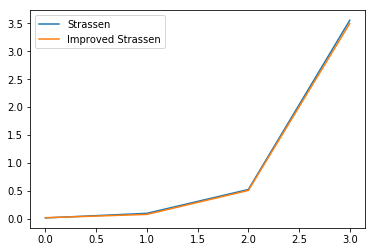

In [14]:
    from random import random, seed
    from sys import stdout
    from timeit import timeit
    import matplotlib.pyplot as plt
    
    time1 = []
    time2 = []
    seed(0)
    for i in range(5, 9):
        size = 2**i
        stdout.write(f'{size}')
        A = Matrix([[random() for x in range(size)] for y in range (size)])
        B = Matrix([[random() for x in range(size)] for y in range (size)])
        #print(strassen_matrix_mult(A,B) - strassen_matrix_mult_less_matr(A,B))
        
        for funct in ['strassen_matrix_mult', 'strassen_matrix_mult_less_matr']:
            T = timeit(f'{funct}(A,B)', globals=locals(), number=1)        #timeit takes a string in input with the command to be executed
            if funct == 'strassen_matrix_mult':
                time1.append(T)
            else:
                time2.append(T)
                
            stdout.write('\t{:.3f}'.format(T))
            stdout.flush()
        stdout.write('\n')

    plt.plot(time1, label = 'Strassen')
    plt.plot(time2, label = 'Improved Strassen')
    plt.legend()

    plt.show()

4) Answer to the following question: how much is the minimum auxiliary
space required to evaluate the Strassen’s algorithm? Motivate the answer.

To compute the Strassen algorithm we need to start allocating $3n^2$ space of memory ( $2n^2$ for the two input matrices $(A,B)$ and $1n^2$ for the output matrix $(C)$ ).
Then we need to execute seven recursive calls in which we need to store 3 more matrices (2 in input, 1 in output) of half of the size. For each recursion step, in order to minimize the auxiliary space, we can think about reusing the same space for the recursive calls. For exampe, when the first call is over, we can add the result to the first and second quadrants of the resulting matrix and then use the memory space to perform the second recursive call. And so on.

In this way, at each recursion step, we are using the following amount of memory:
$$W(n) = 3n^2 + 3({n \over 2})^2$$

So, for the entire algorithm, we have
$$W(n) = 3n^2 + W({n \over 2})$$

We can solve this recurrence:

$W(n) = 3n^2 + W({n \over 2}) = 3n^2 + {3 \over 4} n^2 + {3 \over 4^2} n^2 + W({n \over 8})$ 

$W(n) = 3n^2 * ({1 \over 4} + {1 \over 4^2} + ...) \leq 3n^2 ({{1} \over {1 - {1 \over 4}} }) $
$$ => W(n) \in O(n^2)$$